In [11]:
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='INFO'

import logging

logging.basicConfig(level=logging.INFO)

# Get the root logger and set its level
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [47]:
from src.handlers import Handler, TciaHandler, OpHandler

import torch
import numpy as np
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [45]:
# from monai.apps import download_and_extract
# from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
# from monai.utils import set_determinism


In [13]:
BASE_PATH = 'Data/'
# ...
TCIA_IMG_SUFFIX = '_PV.nii.gz'
TCIA_LOCATION = BASE_PATH + 'TCIA/'
TCIA_EXCEL_NAME = 'HCC-TACE-Seg_clinical_data-V2.xlsx'
# ...
OP_LOCATION = BASE_PATH + 'OP/'
NIFTI_PATH = 'OP_C+P_nifti'
NNU_NET_PATH = 'OP_C+P_nnUnet'
OP_EXCEL = 'OP_申請建模_1121110_20231223.xlsx'
OP_IMG_SUFFIX = '_VENOUS_PHASE.nii.gz'
OP_MASK_SUFFIX = '_VENOUS_PHASE_seg.nii.gz'
OP_ID_COL_NAME = 'OP_C+P_Tumor識別碼'


In [14]:
global_handler = Handler()

tcia = TciaHandler(TCIA_LOCATION, TCIA_IMG_SUFFIX, TCIA_EXCEL_NAME)
global_handler.add_source(tcia)

op = OpHandler(OP_LOCATION, NIFTI_PATH, NNU_NET_PATH, OP_IMG_SUFFIX, OP_MASK_SUFFIX, OP_EXCEL, OP_ID_COL_NAME)
global_handler.add_source(op)

DEBUG:src.handlers:reading file...
INFO:src.handlers:105 rows in the excel file
INFO:src.handlers:Removed 3 stage-d elements
DEBUG:src.handlers:Classifying...
DEBUG:src.handlers:Looking for paths against contents
DEBUG:src.handlers:File not found: Data/TCIA/TCIA_image_PV/HCC_011_PV.nii.gz
DEBUG:src.handlers:File not found: Data/TCIA/TCIA_image_PV/HCC_031_PV.nii.gz
DEBUG:src.handlers:File not found: Data/TCIA/TCIA_image_PV/HCC_082_PV.nii.gz
DEBUG:src.handlers:None
DEBUG:src.handlers:reading file Data/OP/OP_申請建模_1121110_20231223.xlsx
INFO:src.handlers:200 rows in the excel file
INFO:src.handlers:Removed 55 stage-d elements
DEBUG:src.handlers:Classifying...
DEBUG:src.handlers:Looking for paths against contents
DEBUG:src.handlers:Searching for mismatch on files vs excel data...
DEBUG:src.handlers:Returning new dataframe


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   99 non-null     object
 1   img     99 non-null     object
 2   mask    99 non-null     object
dtypes: object(3)
memory usage: 2.4+ KB


DEBUG:src.handlers:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   244 non-null    object
 1   img     244 non-null    object
 2   mask    244 non-null    object
dtypes: object(3)
memory usage: 5.8+ KB


In [17]:
df = global_handler.df

df.head()

,class,img,mask
0,0,Data/TCIA/TCIA_image_PV/HCC_001_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_001_PV.nii.gz
1,2,Data/TCIA/TCIA_image_PV/HCC_002_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_002_PV.nii.gz
2,2,Data/TCIA/TCIA_image_PV/HCC_003_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_003_PV.nii.gz
3,1,Data/TCIA/TCIA_image_PV/HCC_004_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_004_PV.nii.gz
4,2,Data/TCIA/TCIA_image_PV/HCC_005_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_005_PV.nii.gz


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


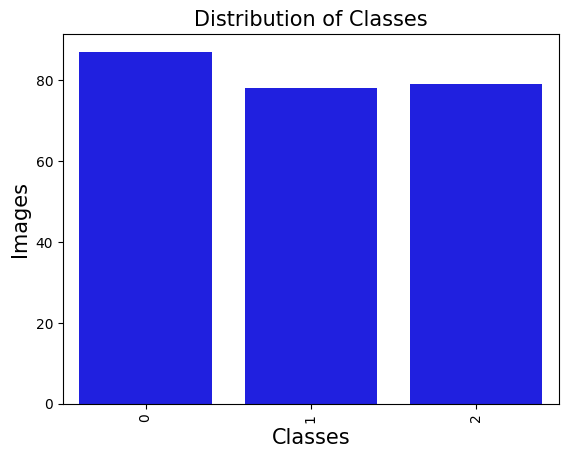

In [18]:
dist = df['class'].value_counts()

sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [28]:
X_train, X_test, y_train, y_test  = train_test_split(
    df[['img', 'mask']],
    df['class'],
    shuffle=True,
    test_size=0.4,
    random_state=8,
    stratify=df['class']
)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


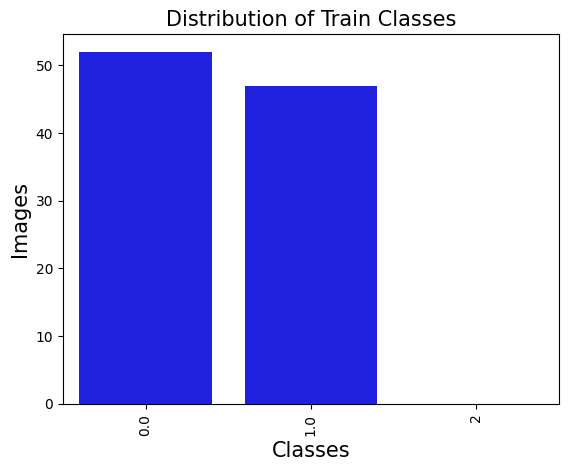

In [29]:
dist = y_train.value_counts()
class_num = len(dist)
sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of Train Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [15]:
dist = y_test.value_counts()

sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of test Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

NameError: name 'y_test' is not defined

[IPKernelApp] Exception in execute request:
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[15], line 1
----> 1 dist = y_test.value_counts()
      3 sns.barplot(x=dist.index, y=dist.values, color='b')
      4 plt.title('Distribution of test Classes', fontsize=15)

NameError: name 'y_test' is not defined


In [36]:
len(y_test) + len(y_train)

class
0.0    35
2      32
1.0    31
Name: count, dtype: int64


244

In [30]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=class_num)])

In [33]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [38]:
train_ds = MedNISTDataset(X_train, y_train, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

In [39]:
val_ds = MedNISTDataset(X_test, y_test, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

In [40]:
test_ds = MedNISTDataset(X_test, y_test, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=3)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=class_num).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [48]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 18

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_117075/379672270.py", line 11, in __getitem__
    return self.transforms(self.image_files[index]), self.labels[index]
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/pandas/core/frame.py", line 4102, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 18


[IPKernelApp] Exception in execute request:
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[48], line 13
     11 epoch_loss = 0
     12 step = 0
---> 13 for batch_data in train_loader:
     14     step += 1
     15     inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

File ~/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/dataloader.py:631, in _BaseDataLoaderIter.__next__(self)
    628 if self._sampler_iter is None:
    629     # TODO(https://github.com/pytorch/pytorch/issues/76750)
    630     self._reset()  # type: ignore[call-arg]
--> 631 data = self._next_data()
    632 self._num_yielded += 1
    633 if self._dataset_kind == _DatasetKind.Iterable and \
    634         self._IterableDataset_len_called is not None and \
    635         self._num_yielded > self._IterableDataset_len_called:

File ~/envs/ai-img/lib/python3.10/site-packages/torch/ut